<a href="https://colab.research.google.com/github/fcoliveira-utfpr/nasapower_validation/blob/main/validation_eto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Import libraries**
---

In [1]:
import numpy as np
import pandas as pd
import datetime
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
%matplotlib inline
%config inlineBackend.figure_formats = ['svg']
import seaborn as sns
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr

#**Data on meteorological elements and their deviations**
---

In [7]:
# Data source URL
url_1 = "https://raw.githubusercontent.com/fcoliveira-utfpr/nasapower_validation/refs/heads/main/elements_and_std.csv"

# Read CSV file
dados = pd.read_csv(url_1)

# Preserve categorical columns
categorical_cols = ['Cidade', 'Base de dados']
dados_cat = dados[categorical_cols].copy()

# Process numerical columns
dados_num = (
    dados
    .drop(columns=categorical_cols)
    .replace(',', '.', regex=True)          # Replace comma with dot as decimal separator
    .apply(pd.to_numeric, errors='coerce')  # Convert to numeric, coercing errors to NaN
)

# Rebuild final DataFrame
dados = pd.concat([dados_num, dados_cat], axis=1)

# Reverse row order and reset index
dados = dados.iloc[::-1].reset_index(drop=True)

dados

,UR (%),Vel (m/s),Rs (Mj/dia),TMax (ºC),Tmin (ºC),Qo (Mj/dia),dp-UR,dp-Vel,dp-Rs,dp-TMax,dp-Tmin,dp-Qo,Cidade,Base de dados
0,77.3,0.7,18.0,28.1,17.5,33.2,11.5,0.2,7.1,4.8,4.8,7.4,Sete Quedas,NASA/POWER
1,66.8,2.0,16.8,28.2,17.5,33.1,14.7,1.2,7.3,6.1,4.9,7.4,Sete Quedas,INMET
2,76.3,0.2,17.7,27.4,16.7,33.0,11.7,0.0,7.4,5.0,4.8,7.9,Planalto,NASA/POWER
3,64.6,2.4,17.7,27.9,17.2,32.9,16.5,1.2,8.1,5.1,4.5,7.8,Planalto,INMET
4,79.8,0.3,17.7,25.2,15.3,32.7,10.4,0.1,6.6,4.0,4.3,7.6,Nova Tebas,NASA/POWER
5,67.2,1.8,17.5,26.9,16.2,32.8,13.1,1.3,7.8,4.3,4.3,7.5,Nova Tebas,INMET
6,74.5,2.1,18.2,28.3,17.0,33.3,11.7,0.7,6.5,4.2,4.2,7.5,Maringá,NASA/POWER
7,63.6,2.1,18.7,28.6,18.3,33.3,14.4,0.7,7.0,4.2,3.6,7.3,Maringá,INMET
8,76.6,1.0,17.8,27.7,16.8,33.0,11.3,0.3,7.3,4.7,4.7,7.7,Marechal Cândido Rondon,NASA/POWER
9,67.9,3.1,17.5,28.5,17.1,33.0,12.2,1.4,7.4,4.9,4.6,7.6,Marechal Cândido Rondon,INMET


##Figure 2

/tmp/ipython-input-1244715386.py:105: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


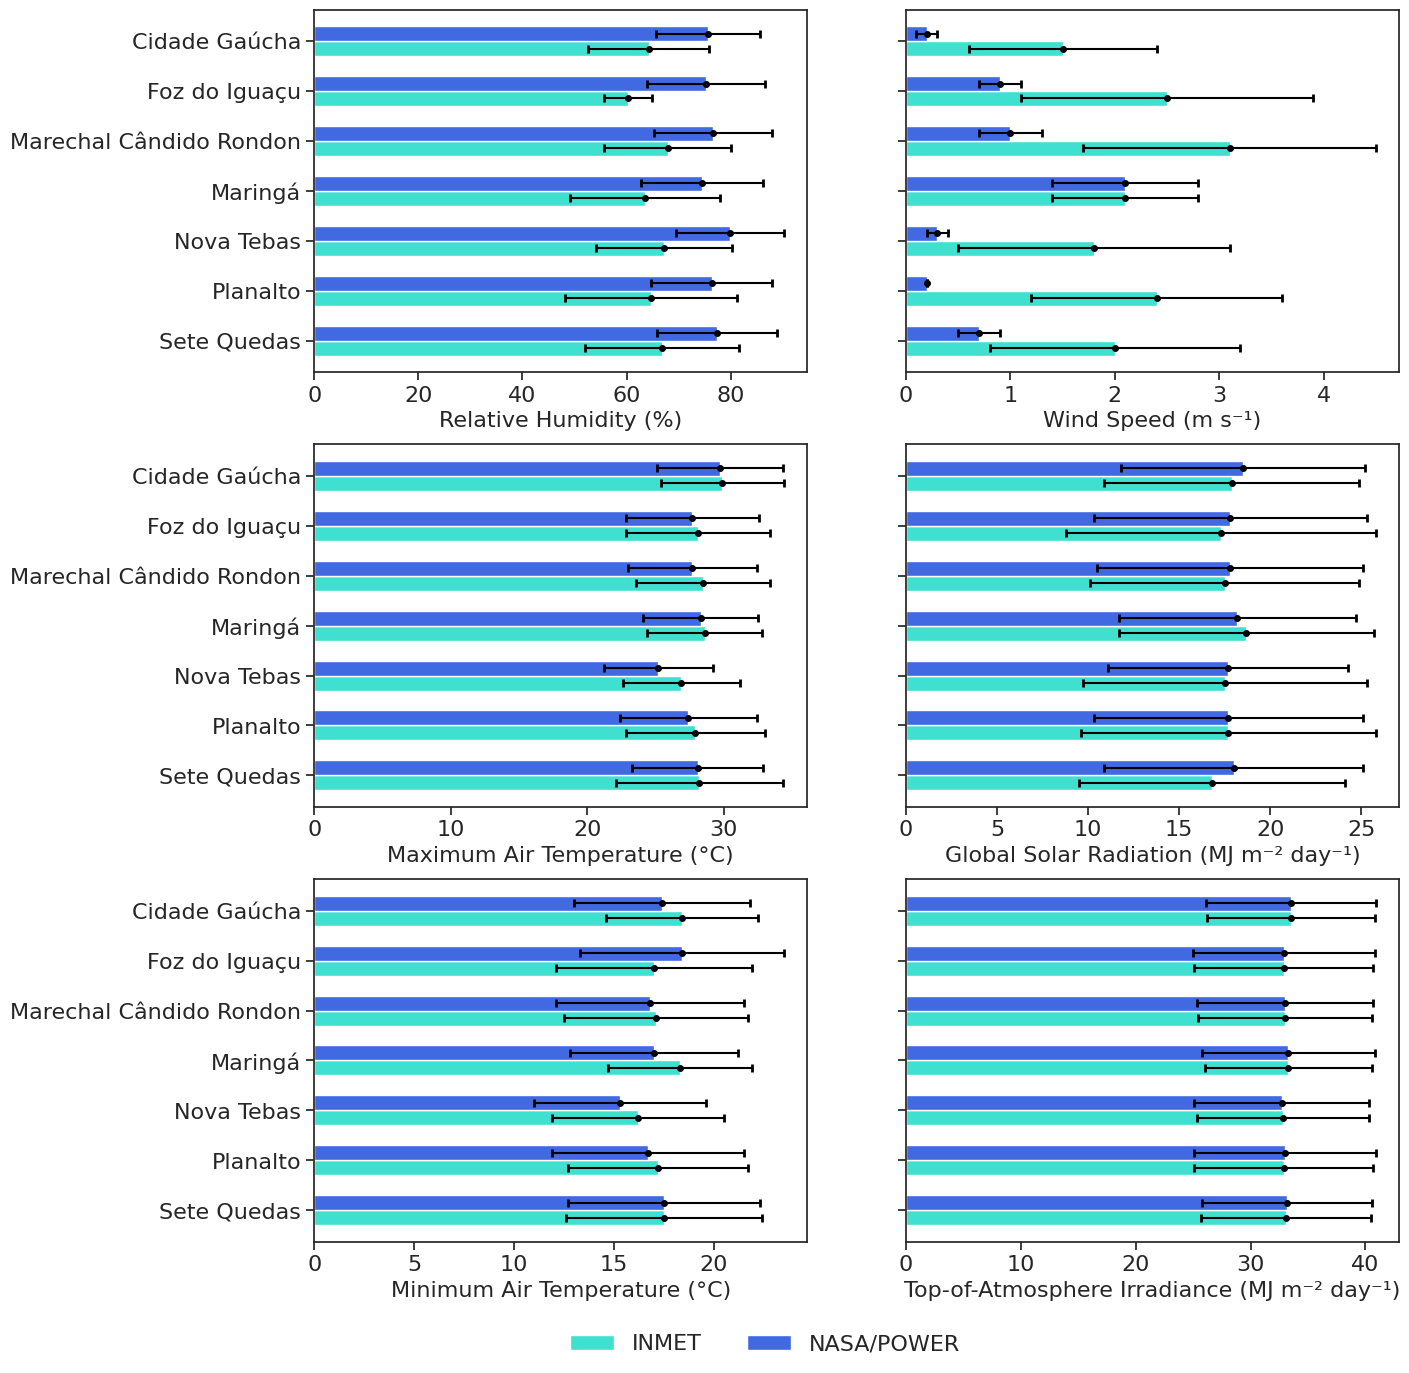

In [11]:
# -------------------------------------------------------------------
# Data filtering by data source
# -------------------------------------------------------------------
inmet = dados[dados['Base de dados'] == 'INMET'].reset_index(drop=True)
npower = dados[dados['Base de dados'] == 'NASA/POWER'].reset_index(drop=True)

cities = npower['Cidade'].tolist()

# -------------------------------------------------------------------
# Plot configuration
# -------------------------------------------------------------------
sns.set()
sns.set_style('ticks')

fig, axs = plt.subplots(
    nrows=3, ncols=2,
    sharey=True,
    figsize=(14, 16)
)

bar_width = 0.3

# -------------------------------------------------------------------
# Helper function to center y-ticks between paired bars
# -------------------------------------------------------------------
def center_ticks(pos, width):
    return pos + width / 2

# -------------------------------------------------------------------
# Generic function to create horizontal bar plots with error bars
# -------------------------------------------------------------------
def plot_variable(ax, var, std, xlabel):
    y_inmet = np.arange(len(inmet[var]))
    y_np = y_inmet + bar_width

    # Horizontal bars
    ax.barh(y_inmet, inmet[var], bar_width, label='INMET', color='turquoise')
    ax.barh(y_np, npower[var], bar_width, label='NASA/POWER', color='royalblue')

    # Error bars
    ax.errorbar(
        inmet[var], y_inmet,
        xerr=inmet[std],
        fmt='o', markerfacecolor='navy', markeredgecolor='black', markeredgewidth=2, markersize=3, ecolor='black', capsize=3
    )
    ax.errorbar(
        npower[var], y_np,
        xerr=npower[std],
        fmt='o', markerfacecolor='navy', markeredgecolor='black', markeredgewidth=2, markersize=3, ecolor='black', capsize=3
    )

    ax.set_xlabel(xlabel, fontsize=16)
    ax.tick_params(axis='both', labelsize=16)

    return y_inmet

# -------------------------------------------------------------------
# Plot each variable
# -------------------------------------------------------------------
y0 = plot_variable(
    axs[0, 0], 'UR (%)', 'dp-UR',
    'Relative Humidity (%)'
)

plot_variable(
    axs[0, 1], 'Vel (m/s)', 'dp-Vel',
    'Wind Speed (m s⁻¹)'
)

plot_variable(
    axs[1, 1], 'Rs (Mj/dia)', 'dp-Rs',
    'Global Solar Radiation (MJ m⁻² day⁻¹)'
)

plot_variable(
    axs[1, 0], 'TMax (ºC)', 'dp-TMax',
    'Maximum Air Temperature (°C)'
)

plot_variable(
    axs[2, 0], 'Tmin (ºC)', 'dp-Tmin',
    'Minimum Air Temperature (°C)'
)

plot_variable(
    axs[2, 1], 'Qo (Mj/dia)', 'dp-Qo',
    'Top-of-Atmosphere Irradiance (MJ m⁻² day⁻¹)'
)

# -------------------------------------------------------------------
# Y-axis labels (cities)
# -------------------------------------------------------------------
plt.yticks(center_ticks(y0, bar_width), cities, fontsize=16)

# -------------------------------------------------------------------
# Legend
# -------------------------------------------------------------------
axs[0, 0].legend(
    fontsize=16,
    frameon=False,
    bbox_to_anchor=(1.35, -2.6),
    ncol=2
)

plt.tight_layout()
"""
Figure 2: Means and standard deviations of the values of relative humidity (RH),
wind speed (U2), global solar radiation (Rs), maximum temperature (Tmax),
minimum temperature (Tmin), and at the top-of-atmosphere irradiance (Qo) from INMET and NASA/POWER
"""

#**Meterics for season**
---

In [14]:
import pandas as pd

# -------------------------------------------------------------------
# Data source URL
# -------------------------------------------------------------------
url_2 = "https://raw.githubusercontent.com/fcoliveira-utfpr/nasapower_validation/refs/heads/main/metricas_season.csv"

# Read CSV file
dados = pd.read_csv(url_2)

# Preserve categorical columns
categorical_cols = ['Cidade', 'Parametro', 'Estacao']
dados_cat = dados[categorical_cols].copy()

# Process numerical columns
dados_num = (
    dados
    .drop(columns=categorical_cols)
    .replace(',', '.', regex=True)          # Convert decimal separator
    .apply(pd.to_numeric, errors='coerce')  # Convert to numeric values
)

# Rebuild final DataFrame
dados = pd.concat([dados_num, dados_cat], axis=1)

dados


,Temp. Max. (C),Temp. Min. (C),Vel. Vento (m/s),Radiacao (MJ/mÂ²),UR Med (%),Qo,Cidade,Parametro,Estacao
0,0.92,0.95,-0.16,0.97,0.55,1.0,PNL,r,inverno
1,0.74,0.79,0.02,0.93,0.60,1.0,PNL,r,primavera
2,0.65,0.64,-0.03,0.86,0.47,1.0,PNL,r,verao
3,0.89,0.95,-0.10,0.96,0.34,1.0,PNL,r,outono
4,0.88,0.90,-0.08,0.97,0.67,1.0,NT,r,inverno
...,...,...,...,...,...,...,...,...,...
107,1.00,0.99,0.41,0.99,0.80,1.0,7Q,d,outono
108,0.99,0.91,0.57,1.00,0.66,1.0,CG,d,inverno
109,0.99,0.99,0.56,1.00,0.98,1.0,CG,d,primavera
110,1.00,0.99,0.61,0.99,0.75,1.0,CG,d,verao


#Figure 3

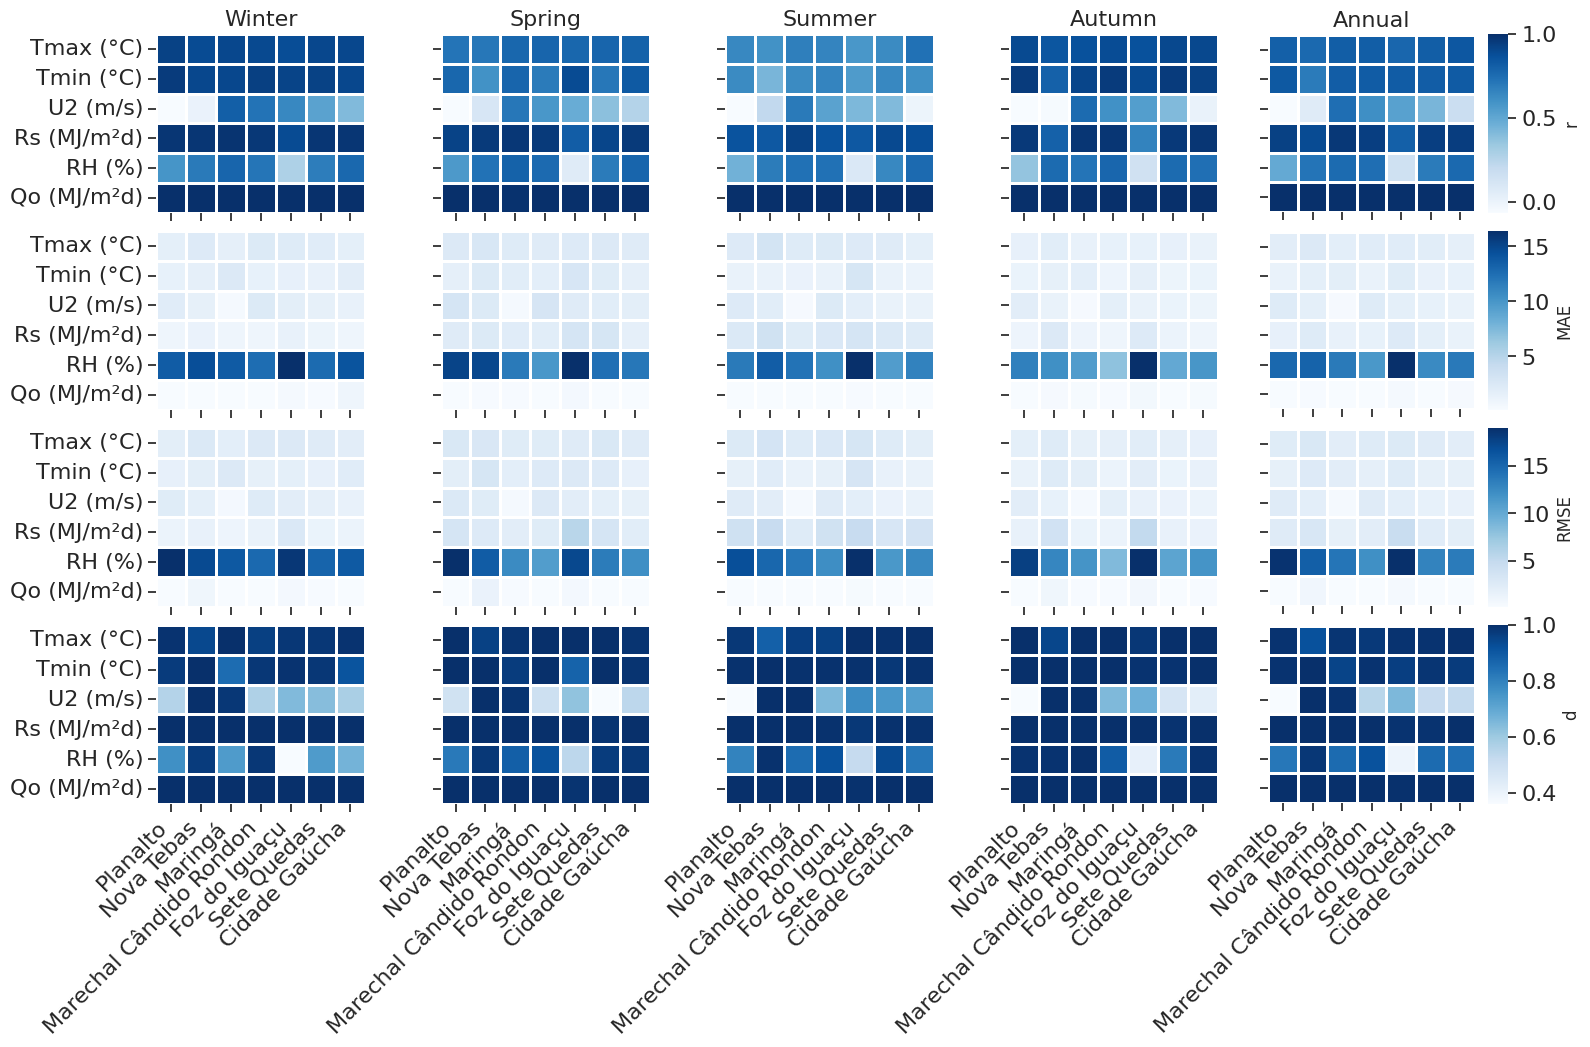

In [15]:
sns.set_style('ticks')

# -------------------------------------------------------------------
# Definitions
# -------------------------------------------------------------------
metrics = ['r', 'MAE', 'RMSE', 'd']
seasons = ['inverno', 'primavera', 'verao', 'outono']

variables = [
    'Temp. Max. (C)',
    'Temp. Min. (C)',
    'Vel. Vento (m/s)',
    'Radiacao (MJ/mÂ²)',
    'UR Med (%)',
    'Qo'
]

row_labels = ['Tmax (°C)', 'Tmin (°C)', 'U2 (m/s)', 'Rs (MJ/m²d)', 'RH (%)', 'Qo (MJ/m²d)']
cities = ['Planalto','Nova Tebas','Maringá','Marechal Cândido Rondon',
          'Foz do Iguaçu','Sete Quedas','Cidade Gaúcha']

cmap = sns.color_palette("Blues", as_cmap=True)

# -------------------------------------------------------------------
# Helper function: build matrix for one metric and one season
# -------------------------------------------------------------------
def build_matrix(df, metric, season):
    subset = df[(df['Parametro'] == metric) & (df['Estacao'] == season)]
    return np.array([subset[var].values for var in variables])

# -------------------------------------------------------------------
# Build all matrices and DataFrames
# -------------------------------------------------------------------
dataframes = {}

for metric in metrics:
    seasonal_dfs = []

    for season in seasons:
        matrix = build_matrix(dados, metric, season)

        df_season = pd.DataFrame(
            matrix,
            index=row_labels,
            columns=cities
        )

        dataframes[(metric, season)] = df_season
        seasonal_dfs.append(df_season)

    # Annual mean
    dataframes[(metric, 'annual')] = sum(seasonal_dfs) / 4

# -------------------------------------------------------------------
# Plot configuration
# -------------------------------------------------------------------
fig, axs = plt.subplots(
    nrows=4, ncols=5,
    sharex=True, sharey=True,
    figsize=(18, 10)
)

plt.rcParams.update({'ytick.labelsize': 16})

titles = ['Winter', 'Spring', 'Summer', 'Autumn', 'Annual']

# -------------------------------------------------------------------
# Plot heatmaps
# -------------------------------------------------------------------
for i, metric in enumerate(metrics):
    for j, season in enumerate(seasons + ['annual']):

        show_cbar = (j == 4)

        sns.heatmap(
            dataframes[(metric, season)],
            cmap=cmap,
            square=True,
            linewidth=1,
            cbar=show_cbar,
            cbar_kws={
                'shrink': 1,
                'aspect': 9,
                'label': metric
            } if show_cbar else None,
            ax=axs[i, j]
        )

        if i == 0:
            axs[i, j].set_title(titles[j], fontsize=16)

# -------------------------------------------------------------------
# Axis labels formatting
# -------------------------------------------------------------------
for ax in axs[-1, :]:
    ax.set_xticklabels(cities, rotation=45, ha='right', fontsize=16)

for ax in axs[:, 0]:
    ax.tick_params(axis='both', labelsize=16)

plt.subplots_adjust(wspace=0.1, hspace=0.1)
"""
Figure 3: Performance of the values of relative humidity (RH),
wind speed (U2), global solar radiation (Rs), maximum temperature (Tmax),
minimum temperature (Tmin),
and top-of-atmosphere irradiance (Qo) from the NASA/POWER reanalysis database
in relation to the INMET surface station data, considering Pearson's correlation (r),
mean absolute error (MAE), root mean square error (RMSE), and Wilmott's concordance index (d)
"""


#**Performance ETo values determined from NASA/POWER data**
---